In [2]:
!python run_mia2.py

nohup: ignoring input and redirecting stderr to stdout


# Analysis

In [6]:
import json
import re
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

output_dir = 'results/target_docs'
output_file = f'{output_dir}/direct_query-nfcorpus-llama3-Top15-M250-N15.json'
with open(output_file, 'r') as f:
    data = json.load(f)

def extract_yes_no(answer):
    """Extract 'Yes' or 'No' from a response."""
    match = re.search(r'\b(Yes|No)\b', answer, re.IGNORECASE)
    return match.group(1).capitalize() if match else "Invalid"

def load_and_calculate_metrics(data):
    expected_answers = []
    predicted_answers = []

    for doc_id, doc_data in data.items():
        expected_answer = "Yes" if doc_data["mem"].lower() == "yes" else "No"
        llm_response = extract_yes_no(doc_data["llm_responses"][0])

        # Skip invalid responses
        if llm_response == "Invalid":
            continue

        expected_answers.append(expected_answer)
        predicted_answers.append(llm_response)

    # Calculate metrics
    accuracy = accuracy_score(expected_answers, predicted_answers) * 100
    precision = precision_score(expected_answers, predicted_answers, pos_label="Yes", zero_division=0)
    recall = recall_score(expected_answers, predicted_answers, pos_label="Yes", zero_division=0)
    f1 = f1_score(expected_answers, predicted_answers, pos_label="Yes", zero_division=0)

    return accuracy, precision, recall, f1

# Calculate and print metrics
accuracy, precision, recall, f1 = load_and_calculate_metrics(data)
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 75.00%
Precision: 0.67
Recall: 0.98
F1 Score: 0.80


# Compare

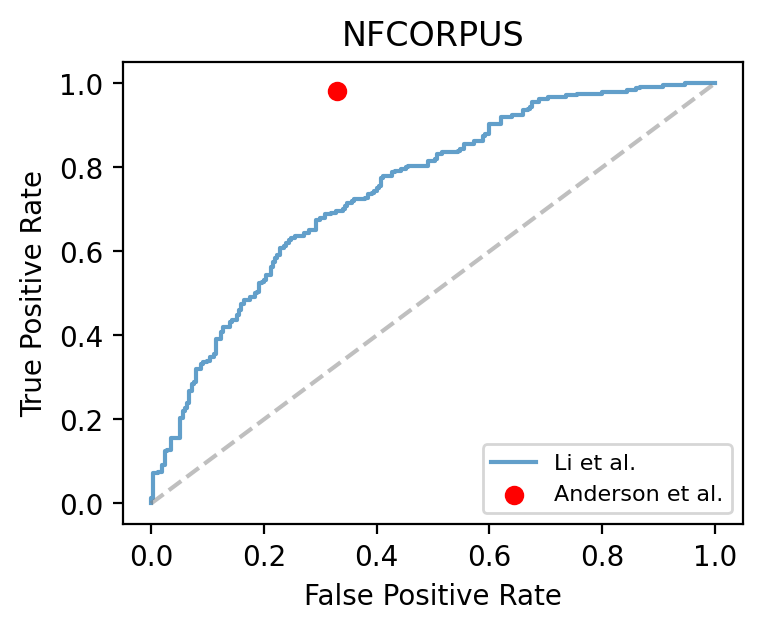

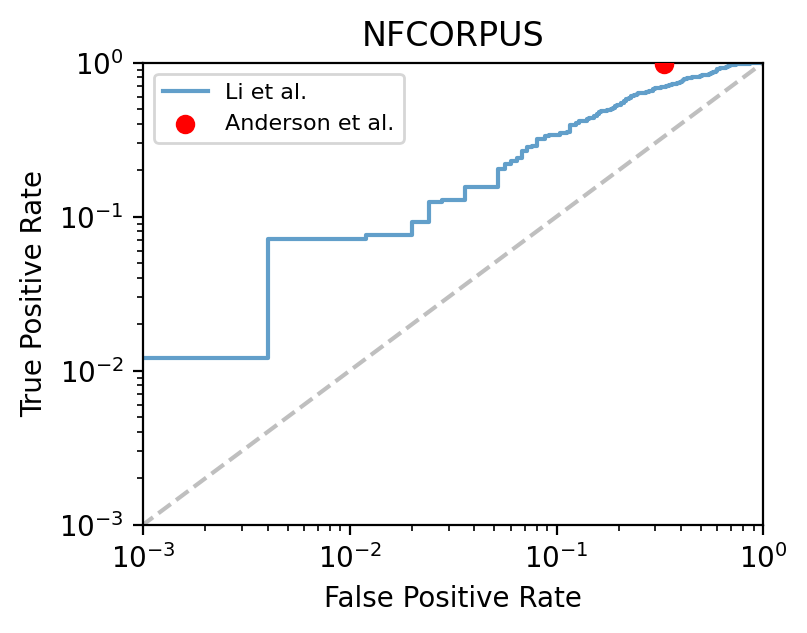

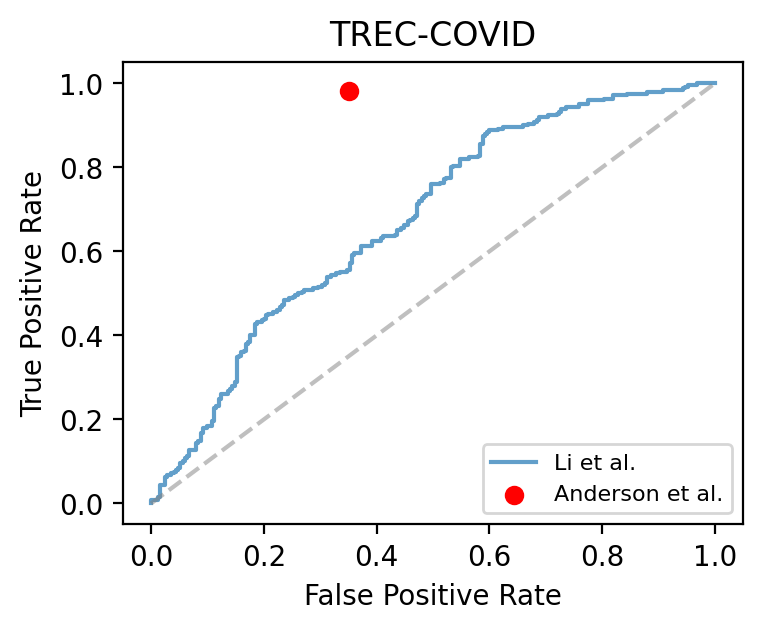

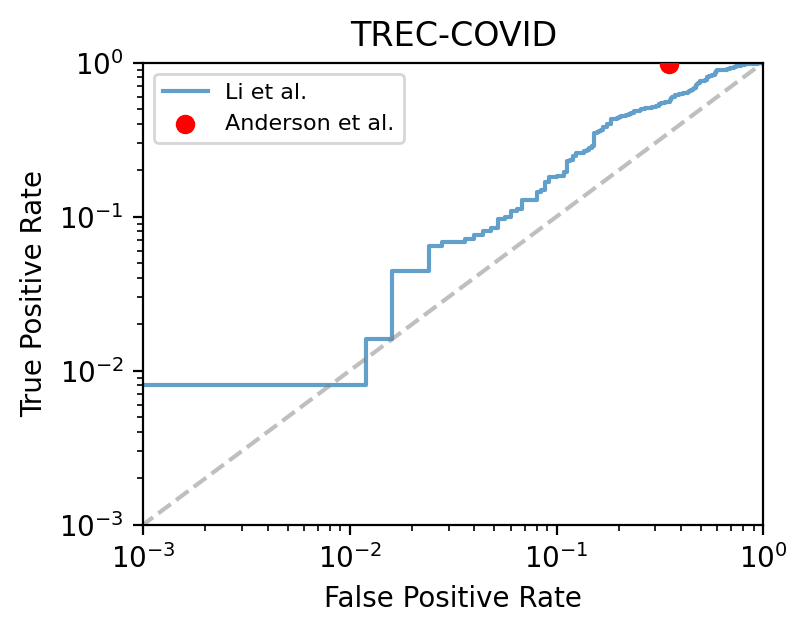

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import json
import os
import re

# Dataset and results directory
output_dir = 'results/target_docs'

# Check if file exists
def file_exists(filepath):
    return os.path.isfile(filepath)

# Function to extract 'Yes' or 'No' from Anderson et al.'s responses
def extract_yes_no(answer):
    match = re.search(r'\b(Yes|No)\b', answer, re.IGNORECASE)
    return match.group(1).capitalize() if match else "Invalid"

# Function to calculate a single ROC point for Anderson et al.
def compute_anderson_point(data):
    """Compute metrics and return a single ROC point."""
    expected_answers, predicted_answers = [], []

    for doc_id, doc_data in data.items():
        expected_answer = 1 if doc_data["mem"].lower() == "yes" else 0
        llm_response = extract_yes_no(doc_data["llm_responses"][0])
        if llm_response == "Invalid":
            continue

        predicted_answer = 1 if llm_response == "Yes" else 0
        expected_answers.append(expected_answer)
        predicted_answers.append(predicted_answer)

    # Calculate metrics
    accuracy = accuracy_score(expected_answers, predicted_answers) * 100
    precision = precision_score(expected_answers, predicted_answers, zero_division=0)
    recall = recall_score(expected_answers, predicted_answers, zero_division=0)
    f1 = f1_score(expected_answers, predicted_answers, zero_division=0)

    # ROC point
    fpr = 1 - precision  # False Positive Rate
    tpr = recall  # True Positive Rate

    return accuracy, precision, recall, f1, fpr, tpr

# Mock function for other attacks' scores
def get_mia_scores(data):
    all_acc = []
    for doc_id, doc_data in data.items():
        correct_answers = doc_data['answers']
        llm_responses = doc_data['llm_responses']
        total_questions = len(correct_answers)
        correct_count = 0

        # Compare LLM responses with correct answers
        for i in range(total_questions):
            correct_answer = extract_yes_no(correct_answers[i])
            llm_answer = extract_yes_no(llm_responses[i])
            if correct_answer == llm_answer:
                correct_count += 1

        # Calculate accuracy for the document
        accuracy = correct_count / total_questions * 100
        all_acc.append(accuracy)
    return all_acc

# Function to plot ROC curves (with or without log scale)
def plot_roc_curves(dataset, attacks_data, anderson_point=None, log_scale=False):
    """Plot TPR vs. FPR with or without log-log axes."""
    plt.figure(figsize=(4, 3), dpi=200)

    for fpr, tpr, label in attacks_data:
        plt.plot(fpr, tpr, label=label, alpha=0.7)

    # Add Anderson et al.'s point if available
    if anderson_point:
        acc, prec, rec, f1, fpr, tpr = anderson_point
        plt.scatter([fpr], [tpr], color='red', label=f"Anderson et al.", zorder=5)

    # Set log-log scale if required
    if log_scale:
        plt.semilogx()
        plt.semilogy()
        plt.xlim(1e-3, 1)
        plt.ylim(1e-3, 1)

    # Add axis labels and legend
    plt.xlabel("False Positive Rate", fontsize=10)
    plt.ylabel("True Positive Rate", fontsize=10)
    plt.plot([0, 1], [0, 1], ls='--', color='gray', alpha=0.5)
    plt.legend(loc="best", fontsize=8)
    plt.title(dataset.upper(), fontsize=12)
    # plt.savefig(f'{log_scale}.png',bbox_inches='tight')
    plt.show()
    


# Prepare data for plotting
datasets = ['nfcorpus', 'trec-covid']
roc_data_by_dataset = {dataset: [] for dataset in datasets}
anderson_points = {}

for dataset in datasets:
    # Process Attack 1: Your attack
    for top in [15]:
        output_file = f'{output_dir}/mia-{dataset}-llama3-Top{top}-M250-N15.json'
        if file_exists(output_file):
            with open(output_file, 'r') as f:
                data = json.load(f)

            all_acc = get_mia_scores(data)
            mem_acc = all_acc[:len(all_acc)//2]
            nonmem_acc = all_acc[len(all_acc)//2:]

            labels = np.concatenate([np.ones(len(mem_acc)), np.zeros(len(nonmem_acc))])
            scores = np.concatenate([mem_acc, nonmem_acc])

            fpr, tpr, _ = roc_curve(labels, scores)
            roc_auc = auc(fpr, tpr)
            roc_data_by_dataset[dataset].append((fpr, tpr, f"Ours (Top-{top})"))
        else:
            print(f"File not found: {output_file}")

    # Process Attack 2: Li et al.
    output_file = f'{output_dir}/s2-{dataset}-llama3-Top15-M250-N15.json'
    if file_exists(output_file):
        with open(output_file, 'r') as f:
            data = json.load(f)

        all_acc = [doc_data['bleu_score'] for doc_data in data.values()]
        mem_acc = all_acc[:len(all_acc)//2]
        nonmem_acc = all_acc[len(all_acc)//2:]

        labels = np.concatenate([np.ones(len(mem_acc)), np.zeros(len(nonmem_acc))])
        scores = np.concatenate([mem_acc, nonmem_acc])

        fpr, tpr, _ = roc_curve(labels, scores)
        roc_auc = auc(fpr, tpr)
        roc_data_by_dataset[dataset].append((fpr, tpr, f"Li et al."))
    else:
        print(f"File not found: {output_file}")

    # Process Attack 3: Anderson et al.
    output_file = f'{output_dir}/direct_query-{dataset}-llama3-Top15-M250-N15.json'
    if file_exists(output_file):
        with open(output_file, 'r') as f:
            data = json.load(f)

        anderson_points[dataset] = compute_anderson_point(data)
    else:
        print(f"File not found: {output_file}")

# Plot for each dataset in both regular and log-log format
for dataset, roc_data in roc_data_by_dataset.items():
    formatted_data = [(fpr, tpr, label) for fpr, tpr, label in roc_data]

    # Regular ROC plot
    plot_roc_curves(dataset, formatted_data, anderson_points.get(dataset), log_scale=False)

    # Log-log ROC plot
    plot_roc_curves(dataset, formatted_data, anderson_points.get(dataset), log_scale=True)
